# Desarrollo de un modelo de análisis de sentimientos a partir de datos recuperados por twipper

**por Álvaro Bartolomé del Canto @ alvarob96 en GitHub**

---
## Introducción

A lo largo de este informe, se presentará el proceso de creación de un modelo de análisis de sentimientos en español, en base a los tweets previamente extraídos con [twipper](https://github.com/alvarob96/twipper) y categorizados de forma supervisada a través de la plataforma **tcue_sentiment**.

Para la creación de este modelo, primero se hará un análisis exploratorio de los datos, es decir, de los tweets originales ya etiquetados e insertados en un `pandas.DataFrame` (recuperados de **MongoDB**, ya que este es el sistema de almacenamiento propio de **tcue_platform**). Después, se hará uso del modelo de lenguaje creado para el español, que se basa en la limpieza y tokenización del texto de entrada, lo cual a su vez, más adelante, servirá de entrada al modelado. Finalmente, para crear el modelo, se aplicará un algoritmo de **Feature Extraction**, seguido de un **Classifier**, que sea capaz de clasificar nuevos tweets de entrada en cada una de las categorías determinadas por sentimiento (negativo, neutral y positivo).

Destacar que el punto fuerte de dicha propuesta consiste en la elaboración de un sistema de **NLP en español**, que combinando una serie de técnicas de análisis de lenguaje junto con algoritmos de **Machine Learning**, darán lugar a la creación de un **modelo de análisis de sentimientos en español**.

---
## Recuperación de los Datos

In [188]:
import warnings
warnings.filterwarnings('ignore')

In [189]:
import pandas as pd
import pickle

De este modo, inicialmente se procederá a la carga de los datos a través de [pickle](https://docs.python.org/3/library/pickle.html), que es un sistema para la serialización de objetos en Python que almacena su contenido sobre un fichero de texto, que posteriomente, podrá ser leido directamente sobre un objeto de Python de igual forma.

In [190]:
with open('resources/sentiment.pickle', 'rb') as pick:
    df = pickle.load(pick)

In [191]:
df.head()

,sentiment,tweet
0,positive,Impresionante como siempre la última temporada...
1,neutral,"Esta acción, que hasta ahora se tenía que inte..."
2,neutral,"Ladran, Sancho, señal que cabalgamos Bona nit!"
3,neutral,Se q alguien cuando lo lea se le caeran lágrim...
4,positive,Bueno toca descansar mañana pa Córdoba


---
## Análisis Exploratorio de los Datos

Para realizar el análisis exploratorio de los datos, dado que el `pandas.DataFrame` tan solo contiene dos columnas, seré breve. De este modo, se calculará y analizará la longitud de cada uno de los tweets ya clasificados y se buscará una posible correlación entre la longitud de un tweet para con el sentimiento con el que se ha categorizado de forma supervisada previamente a través de la plataforma **tcue_sentiment**.

In [181]:
df['tweet_length'] = df['tweet'].str.len()

In [182]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

Se mostrará la distribución de la longitud de los tweets de entre todos los tweets contenidos en el `pandas.DataFrame`, para así poder determinar cúal es la longitud "normal" de un tweet.

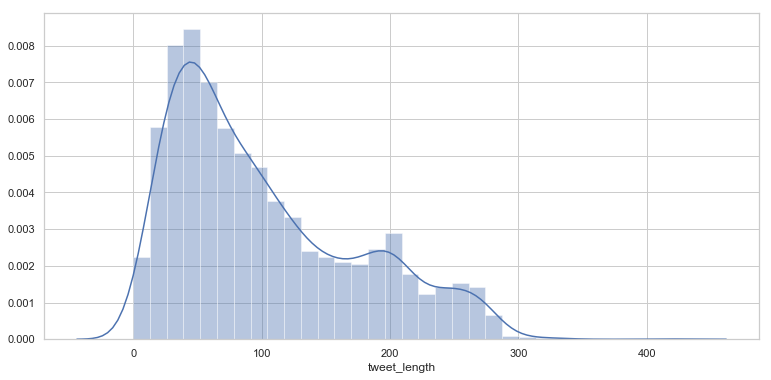

In [183]:
plt.figure(figsize=(12.8,6))

sns.distplot(df['tweet_length'])

De la distribución anterior, se determina que la longitud de un tweet por lo general suele estar por debajo de los 100 caracteres, lo cual implica que la mayoría de tweets son opiniones directas y ausentes de un gran contenido, con lo que las palabras relevantes, de cara al modelado, de cada uno de dichos tweets serán pocas. Es más raro ver tweets con una longitud mayor de 100, pero aún así dichos tweets también están presentes en el `pandas.DataFrame`.

---
Ahora, se mostrará un gráfico de barras con el fin de determinar cúantos tweets se han clasificado de forma supervisada a través de la plataforma **tcue_sentiment**, para así poder determinar la tendencia a la hora de publicar tweets.

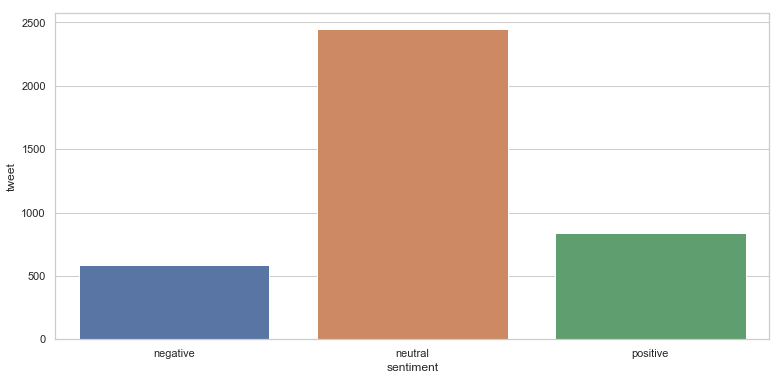

In [184]:
plt.figure(figsize=(12.8,6))

aux = df.groupby('sentiment').count()

sns.barplot(data=aux, x=aux.index, y='tweet')

Tal y como se puede observar en el gráfico de barras previamente mostrado, la cantidad de tweets que han sido categorizados como neutrales es notoriamente superior a los que se han clasificado bien como positivos o bien como negativos, de forma supervisada. Con esto, dadas las muestras tomadas se deduce que la opinión general en Twitter tiene un sentimiento neutral, mientras que la positiva y la negativa van más o menos a la par.

---
Por último, se realizará una representación cruzada de las mencionadas anteriormente, donde se observa la distribución cuantitativa de los datos previamente mencionados comparando así la longitud de un tweet con el sentimiento al que pertenece, con el fin de determinar si el sentimiento está de algún modo relacionado con el tamaño del tweet.

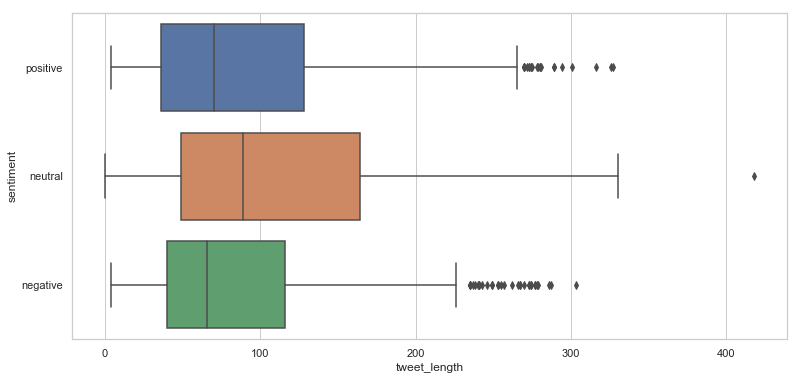

In [185]:
plt.figure(figsize=(12.8,6))

sns.boxplot(data=df, x='tweet_length', y='sentiment')

De esta gráfica extraemos la conclusión de que, por lo general, la longitud de los tweets neutrales suele ser algo mayor que la longitud de los positivos y negativos; aunque dado que hay más tweets neutrales en el `pandas.DataFrame`, el dato tampoco es muy revelador.

---
## Limpieza y Pre-Procesamiento de los Tweets

In [14]:
def get_stopwords():
    stopwords_list = list()

    with open('resources/stopwords-es.txt', 'rt', encoding='utf-8') as stopwords:
        for stopword in stopwords.readlines():
            stopwords_list.append(stopword.strip())

        stopwords.close()
        
    return stopwords_list

In [22]:
import re

In [23]:
def tokenizer(tweet, stopwords_list):
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    html_pattern = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    spaces_pattern = re.compile('[ ]{2,}')
    
    result = url_pattern.sub('', tweet)
    result = html_pattern.sub('', result)
    result = spaces_pattern.sub('', result)
    result = re.findall('\w+', result)
    
    result = ' '.join([word.lower() for word in result if word.lower() not in stopwords_list])
    
    return result

In [24]:
stopwords_list = get_stopwords()

In [25]:
results = [tokenizer(tweet, stopwords_list) for tweet in df['tweet']]

In [26]:
df['tokenized'] = results

In [27]:
df

,sentiment,tweet,tweet_length,tokenized
0,neutral,Pues bueno ya terminé la cosa esta,34,terminé cosa
1,negative,Atención SUBNORMAL RETRATADA.,29,atención subnormal retratada
2,negative,De verdad que si esto es una broma puto paradl...,70,broma puto paradla gracia
3,neutral,Nuestro Menú Especial disponible tiene esta ca...,184,menú especial disponible cara apetecible comid...
4,positive,Ayyyy que monerías de sandalias es parteras am...,137,ayyyy monerías sandalias parteras amores llega...
...,...,...,...,...
3865,negative,"Sanemci que Can también ha sufrido, irse y dej...",82,sanemci can sufrido irse dejarte duro nuevoser...
3866,negative,"Señor Escolar, no tiene algún artículo más nue...",90,señor escolar artículo limpie culo
3867,negative,ACEPTO EL RETO de este experimento social llam...,219,acepto reto experimento social llamadoquiero h...
3868,negative,He visto como una chica se fumaba el cigarrill...,127,visto chica fumaba cigarrillo orilla tirado ma...


---
## Modelo de Análisis de Sentimiento

### Preparación de las Etiquetas

In [28]:
df[df['sentiment'] == 'negative']['tokenized'].tolist()[:2]

['atención subnormal retratada', 'broma puto paradla gracia']

In [30]:
sentiment_codes = {
    'negative': -1,
    'neutral': 0,
    'positive': 1,
}

In [31]:
df['sentiment_code'] = df['sentiment']
df = df.replace({'sentiment_code': sentiment_codes})

In [32]:
negative = df[df['sentiment'] == 'negative']

In [33]:
neutral = df[df['sentiment'] == 'neutral']

In [34]:
positive = df[df['sentiment'] == 'positive']

In [35]:
train = pd.concat([negative, neutral, positive], ignore_index=True)

In [36]:
from sklearn.utils import shuffle

In [37]:
train = shuffle(train)

In [77]:
train.reset_index(drop=True, inplace=True)

In [78]:
import pickle

In [79]:
with open('sentiment.pickle', 'wb') as pico:
    pickle.dump(train, pico)

In [80]:
with open('sentiment.pickle', 'rb') as pico:
    caca = pickle.load(pico)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train['tokenized'],
                                                    train['sentiment_code'],
                                                    test_size=0.10, 
                                                    random_state=8)

---
### Feature Extraction

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        max_features=10000,
                        norm='l2',
                        sublinear_tf=True)

In [43]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train

In [44]:
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test

In [45]:
from sklearn.feature_selection import chi2
import numpy as np

In [46]:
for sentiment, sentiment_id in sorted(sentiment_codes.items()):
    features_chi2 = chi2(features_train, labels_train == sentiment_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    print("# '{}' category:".format(sentiment))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("")

# 'negative' category:
  . Most correlated unigrams:
. triste
. heterótrofa
. odio
. puta
. mierda

# 'neutral' category:
  . Most correlated unigrams:
. amo
. gracias
. feliz
. puta
. mierda

# 'positive' category:
  . Most correlated unigrams:
. bonito
. amo
. enhorabuena
. feliz
. gracias



---
### Algoritmo de Clasificación

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
knn = KNeighborsClassifier()

In [49]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [50]:
params = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [15, 30, 45],
    'n_neighbors': [5, 10, 25, 50, 100],
}

In [53]:
# from sklearn.model_selection import GridSearchCV

In [52]:
# gridsearch = GridSearchCV(estimator=knn, param_grid=params, cv=5, n_jobs=1)

In [284]:
# gridsearch.fit(features_train, labels_train)

In [285]:
# gridsearch.best_params_

In [286]:
# gridsearch.cv_results_['mean_test_score']

In [287]:
knn.fit(features_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [288]:
pred = knn.predict(features_test)

In [289]:
pred

array([ 0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,
       -1,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1, -1, -1,
        0,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0,  0,  0, -1, -1,
        0,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0,  0, -1,  0, -1, -1,  0,
        0,  0, -1,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1,
       -1, -1,  0,  0, -1,  0,  0,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,
        0,  1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0,
        0, -1,  0,  0,  0,  0, -1,  0, -1,  0, -1, -1, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0, -1,  0, -1, -1,  0,  0,
       -1,  1,  0,  0,  0

In [65]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(labels_train, knn.predict(features_train))

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
forest = RandomForestClassifier()

In [56]:
forest.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

In [58]:
countvec = CountVectorizer(analyzer = "word")

In [59]:
countvec_train = countvec.fit_transform(X_train)

In [60]:
countvec_test = countvec.transform(X_test)

In [61]:
forest.fit(countvec_train, y_train)

c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
pred = forest.predict(countvec_test)

In [66]:
accuracy_score(pred, y_test)

0.6227390180878553

In [67]:
vectorizer = CountVectorizer(strip_accents='unicode',
                             lowercase=True,
                             analyzer='word')

In [68]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

---
# aaaaa

In [129]:
from sklearn.naive_bayes import MultinomialNB

In [130]:
multinb = MultinomialNB()

In [131]:
multinb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [132]:
import numpy as np

In [133]:
params = {
    'alpha': [round(value, 1) for value in np.arange(0, 1, .1)],
    'fit_prior': [True, False]
}

In [120]:
from sklearn.model_selection import GridSearchCV

In [134]:
gridsearch = GridSearchCV(estimator=multinb, param_grid=params, cv=5, n_jobs=1)

In [135]:
gridsearch.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [136]:
gridsearch.best_params_

{'alpha': 0.5, 'fit_prior': True}

In [137]:
gridsearch.cv_results_['mean_test_score']

array([0.57393052, 0.55612977, 0.5601493 , 0.4039621 , 0.60465116,
       0.4137238 , 0.62360034, 0.42492105, 0.64025266, 0.43870227,
       0.64685616, 0.44932529, 0.64341085, 0.4559288 , 0.64053976,
       0.46482917, 0.63853   , 0.472294  , 0.63824289, 0.47918461])

---
# bbbbbbb

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
forest = RandomForestClassifier()

In [140]:
forest.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [159]:
params = {
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100],
}

In [160]:
from sklearn.model_selection import GridSearchCV

In [161]:
gridsearch = GridSearchCV(estimator=forest, param_grid=params, cv=5, n_jobs=1)

In [162]:
gridsearch.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [163]:
gridsearch.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'n_estimators': 100}

In [164]:
gridsearch.cv_results_['mean_test_score']

array([0.65575653, 0.65518231, 0.65518231, 0.65403388, 0.65747918,
       0.65747918])

---
# ccccc

In [ ]:
classifiers = [
    RandomForestClassifier(),
    GaussianNB(),
    MultinomialNB()
]

In [126]:
multinb = MultinomialNB(alpha=.5, fit_prior=True)
multinb.fit(features_train, labels_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [127]:
y_predicted = multinb.predict(features_test)

In [121]:
gridsearch = GridSearchCV(estimator=multinb, param_grid=params, cv=5, n_jobs=1)

In [122]:
gridsearch.fit(features_train, labels_train)

c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [124]:
gridsearch.best_params_

{'alpha': 0.5, 'fit_prior': True}

In [125]:
gridsearch.cv_results_['mean_test_score']

array([0.57393052, 0.55612977, 0.5601493 , 0.4039621 , 0.60465116,
       0.4137238 , 0.62360034, 0.42492105, 0.64025266, 0.43870227,
       0.64685616, 0.44932529, 0.64341085, 0.4559288 , 0.64053976,
       0.46482917, 0.63853   , 0.472294  , 0.63824289, 0.47918461])

In [128]:
multinb.score(features_test, labels_test)

0.6434108527131783

---
## Licencia

MIT License

Copyright (c) 2019 Álvaro Bartolomé del Canto

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---
## Autor

**Álvaro Bartolomé del Canto, 2018-2019**